In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

---

In [3]:
from Bio import SeqIO

In [4]:
from Bio.SeqUtils import IUPACData
IUPACData.protein_letters_3to1['Sec'] = 'U'

In [5]:
csa_db = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/M-CSA/CSA_proteins_full_list.csv',
                    names=['MCSA-ID',
                           'Uniprot_ID',
                           'PDB','EC','Type',
                           'Residue_ID','Chain',
                           'Residue_Index','FuncLocation',
                           'Role','RoleType',
                           'RoleGroup']
                    )
csa_db = csa_db[csa_db['Type'] == 'residue']
csa_db['Residue_Single'] = csa_db.Residue_ID.apply(lambda x: IUPACData.protein_letters_3to1[x.title()])
binding_sites = csa_db[['Uniprot_ID','Type','Residue_Index','Residue_ID','Residue_Single','RoleType']]
binding_sites = binding_sites.drop_duplicates(['Uniprot_ID','Residue_Index','Residue_ID'])
binding_sites = binding_sites.set_index('Uniprot_ID')
binding_sites.to_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/M-CSA/CSA_binding_sites_clean.csv',
                     sep=',',index=True,header=True)
binding_sites = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/M-CSA/CSA_binding_sites_clean.csv',
                           index_col=0)

In [6]:
rec = list(SeqIO.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/M-CSA/dti_dg_overlap.fasta','fasta'))
for r in rec:
    r.name = r.name.split('|')[1]
    r.id = r.name
seqDict = {r.id: r for r in rec if r.id in binding_sites.index.unique()}

In [7]:
seqDict.keys()

dict_keys(['P00918', 'P09960', 'P11766', 'Q04828', 'P05164', 'P06213', 'P29466', 'P42574', 'P47712', 'P27487', 'Q92831', 'P04062', 'P25774', 'P62937', 'P00750', 'P07237', 'P00747', 'P18031', 'Q02127', 'P27695', 'P05091', 'Q14790', 'P00374'])

In [8]:
off_by_dict = {}
off_by_tries = [int(-np.floor(n/2)*(-1)**n) for n in range(1,42)]

def get_off_by_vect(pid, binding_sites, seqDict):
    try:
        off_by_vect = []
        off_by_ind = 0
        for i, row in binding_sites.loc[pid].reset_index().iterrows():
            if seqDict[pid].seq[row.Residue_Index - off_by_tries[off_by_ind]] == row.Residue_Single:
                # continue
                off_by_vect.append(off_by_tries[off_by_ind])
            else:
                off_by_ind = 0
                while seqDict[pid].seq[row.Residue_Index - off_by_tries[off_by_ind]] != row.Residue_Single:
                    off_by_ind += 1
                off_by_vect.append(off_by_tries[off_by_ind])
        # print(pid, off_by_vect)
        return off_by_vect
    except IndexError as e:
        # print(pid, e)
        return None
    

for pid in seqDict.keys():
    off_by_dict[pid] = get_off_by_vect(pid, binding_sites, seqDict)

In [9]:
def get_mutation_mask(pid, binding_sites, seqDict):
    seq = seqDict[pid]
    bs_df = binding_sites.loc[pid]
    
    off_by_vect = get_off_by_vect(pid, binding_sites, seqDict)
    true_idx = [(r.Residue_Index - offset) for ((_,r),offset) in zip(bs_df.iterrows(), off_by_vect)]
    
    mask = np.array([1 if i in true_idx else 0 for i in range(len(seq))])
    return mask

def verify_mask(pid, mask, binding_sites, seqDict):
    seq = seqDict[pid]
    tmpdf = pd.DataFrame(binding_sites.loc[pid].Residue_Single)
    tmpdf['Residue_Mask'] = [seq[i] for i in range(len(seq)) if mask[i]]
    return tmpdf

In [10]:
binding_site_masks = {pid:get_mutation_mask(pid,binding_sites,seqDict) for pid in seqDict.keys() if get_off_by_vect(pid,binding_sites,seqDict) is not None} 

In [11]:
def sample_aa():
    from random import choice
    aa_set = list(IUPACData.protein_letters_3to1.values())
    return choice(aa_set)
    
def mutate_aa_seq(seq, mask):
    new_aa = []
    for i, r in enumerate(seq):
        if mask[i]:
            new_aa.append(sample_aa())
        else:
            new_aa.append(r)
    return ''.join(new_aa)

In [12]:
binding_site_masks[pid]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
pid = 'Q14790'
mutate_aa_seq(seqDict[pid], binding_site_masks[pid])

'MDFSRNLYDIGEQLDSEDLASLKFLSLDYIPQRKQEPIKDALMLFQRLQEKRMLEESNLSFLKELLFRINRLDLLITYLNTRKEEMERELQTPGRAQISAYRVMLYQISEEVSRSELRSFKFLLQEEISKCKLDDDMNLLDIFIEMEKRVILGEGKLDILKRVCAQINKSLLKIINDYEEFSKERSSSLEGSPDEFSNGEELCGVMTISDSPREQDSESQTLDKVYQMKSKPRGYCLIINNHNFAKAREKVPKLHSIRDUNGTHLDAGALTTTFEELHFEIKPHDDCTVEQIYEILKIYQLMDHSNMDCFICCILSYGDKGIIYGTDGQEAPIYELTSQFTGLKCPSLAVKPKVFFIQASQGDNYQKGIPVETDSEEQPYLEMDLSSPQTRYIPDEADFLLGMATVNNCVSYRNPAEGTWYIQSLCQSLRERCPRGDDILTILTEVNYEVSNKDDKKNMGKQMPQPTFTLRKKLVFPSD'

In [14]:
# Load model
from architectures import SimplePLMModel, SimpleCosine
from mol_feats import Morgan_f
from prot_feats import ProtBert_f
mol_f = Morgan_f()
prot_f = ProtBert_f()
# model = torch.load("../best_models/dti_dg_morganM_protbertP_bm_best_model.sav").cuda()
model = torch.load("../best_models/bindingdb_morgan_protbert_best_model.sav").cuda()

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html

In [15]:
links = pd.read_csv(f'{BASE_DIR}/nbdata/dti_dg_group/bindingdb_patent/train_val.csv')

In [16]:
bait_projections = {}
mutated_projections = {}
true_projections = {}

for pid in binding_site_masks.keys():
    pid_links = links[links.Target_ID == pid]
    bait_pl = []
    mutated_pl = []
    
    with torch.set_grad_enabled(False):
        for m in tqdm(pid_links.Drug):
            m_emb = mol_f(m).cuda()
            m_proj = model.mol_projector(m_emb).detach().cpu().numpy()
            bait_pl.append(m_proj)
        for _ in tqdm(range(50)):
            mut_seq = mutate_aa_seq(seqDict[pid], binding_site_masks[pid])
            p_proj = model.prot_projector(prot_f(mut_seq).cuda()).cpu().numpy()
            mutated_pl.append(p_proj)
        true_proj = model.prot_projector(prot_f(str(seqDict[pid].seq)).cuda()).cpu().numpy()
        
    bait_projections[pid] = bait_pl
    mutated_projections[pid] = mutated_pl
    true_projections[pid] = true_proj

  0%|          | 0/55 [00:00<?, ?it/s]

[09:09:43] Explicit valence for atom # 20 N, 4, is greater than permitted


rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features


[09:09:43] Explicit valence for atom # 20 N, 4, is greater than permitted
[09:09:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[09:09:43] Explicit valence for atom # 10 N, 4, is greater than permitted
[09:09:43] Explicit valence for atom # 10 N, 4, is greater than permitted
[09:09:43] Explicit valence for atom # 17 N, 4, is greater than permitted
[09:09:43] Explicit valence for atom # 20 N, 4, is greater than permitted
[09:09:43] Explicit valence for atom # 4 N, 4, is greater than permitted


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

[09:13:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[09:13:59] Explicit valence for atom # 19 N, 4, is greater than permitted
[09:13:59] Explicit valence for atom # 19 N, 4, is greater than permitted


rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features
rdkit not found this smiles for morgan: None convert to all 0 features


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

rdkit not found this smiles for morgan: None convert to all 0 features


[09:17:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 10 12


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
pid_list = list(binding_site_masks.keys())

In [58]:
pid = pid_list[19]

In [59]:
from sklearn.manifold import TSNE

bp_pid = bait_projections[pid]
mp_pid = mutated_projections[pid]
tp_pid = true_projections[pid]

all_projections = np.concatenate([bp_pid,mp_pid,[tp_pid]],axis=0)
project_tsne = TSNE(metric="cosine").fit_transform(all_projections)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.fl

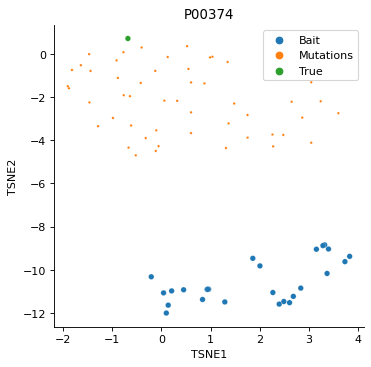

In [60]:
hue = ['Bait']*len(bp_pid)+['Mutations']*len(mp_pid)+['True']
size = [25]*len(bp_pid)+[5]*len(mp_pid)+[25]
plt.figure(figsize=(5, 5), dpi=80)
sns.scatterplot(x=project_tsne[:,0],
                y=project_tsne[:,1],
                hue=hue,
                s=size
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title(pid)
sns.despine()
plt.show()

In [61]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

mutated_scores = []
true_scores = []

with torch.set_grad_enabled(False):
    for mProj in tqdm(bp_pid):
        for pProj in tqdm(mp_pid):
            affin = cosine_sim(torch.from_numpy(pProj).cuda(),torch.from_numpy(mProj).cuda()).cpu().numpy()
            mutated_scores.append(float(affin))
        affin = cosine_sim(torch.from_numpy(tp_pid).cuda(),torch.from_numpy(mProj).cuda()).cpu().numpy()
        true_scores.append(float(affin))
        
df = pd.DataFrame({"scores":mutated_scores + true_scores,"label":(['mutated']*len(mutated_scores))+(['true']*len(true_scores))})

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

-0.5192547728281648 0.6981650632173924


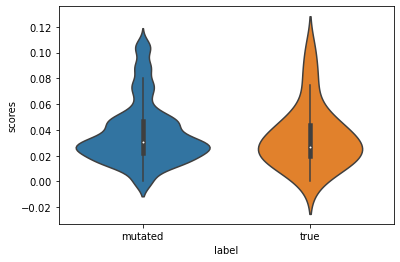

In [62]:
import scipy
stat, pvalue = scipy.stats.ttest_ind(df[df['label'] == 'true']['scores'], df[df['label'] == 'mutated']['scores'],alternative='greater')
print(stat, pvalue)
sns.violinplot(data=df, x='label', y='scores')
plt.show()